# Задача 1. Разведочный анализ

* **Дедлайн**: 08.10.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно скачать данные (из открытых источников по интересующей тематике, на сайте [kaggle](https://www.kaggle.com), [UCI](https://archive.ics.uci.edu/ml/datasets.php) репозитория, [Google Dataset Search](https://datasetsearch.research.google.com/) и др.). Для полного балла нужно выбрать данные, в которых есть пропущенные значения.
- [x] Считать данные и вывести их основные характеристики, описание признаков.
- [x] Сформулировать задачу предсказания, какой признак интересно было бы предсказывать по остальным.
- [x] (+2 балла) Произвести чистку данных (**Data Cleaning**). Например, заполнить пропущенные значения чем то осмысленным для поставленной задачи.
- [x] Провести анализ признаков, используя визуализацию (**hist(), boxplot(), countplot(), barplot()** и тд), сделать выводы, которые могут быть полезны при дальнейшем решении задачи предсказания.
- [x] (+1 балл) Оценить зависимость между признаками (визуализация или построение матрицы корреляции).
- [x] (+2 балла) Выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные если это нужно), убрать ненужные признаки, создать новые (**Feature Engineering**).

In [32]:
import pathlib

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

pandas.set_option("display.max_columns", None)

madrid_houses_dataset_path = pathlib.Path().cwd().resolve() / "datasets" / "madrid_houses.csv"

# EDA
## Dataset

Используем набор данных Мадрида рынка недвижимости - [Madrid houses](https://www.kaggle.com/datasets/makofe/housesclean)

Предполагается решать задачу регрессии: определить цену домов по демографическим данным и географическому положению относительно Мадрида.

Нецелевые аттрибуты:

- sq_mt_built — размер дома в кв.м
- n_rooms — количество комнат
- n_bathrooms — количество ванных комнат
- n_floors — количество этажей
- sq_mt_allotment — общая площадь участка
- floor — высота
- is_renewal_needed — требуется обновление / ремонт
- has_lift — наличие лифта
- is_exterior — внешняя часть здания
- energy_certificate — чем больше число, тем эффективнее
- has_parking — наличие парковки
- neighborhood — округ / графство
- district — район
- house_type — тип дома (квартира, дом, кабинет, дуплекс, верхний этаж)

Целевой аттрибут:

- buy_price — цена дома

In [42]:
madrid_houses_dataset = pandas.read_csv(
    madrid_houses_dataset_path, sep=',',
    header=0, index_col=0, encoding="utf-8"
).drop(columns=["id"])

madrid_houses_dataset.describe()

,sq_mt_built,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,buy_price,energy_certificate,neighborhood,district,house_type
count,21740.000000,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000,2.174000e+04,21742.000000,21742.000000,21742.000000,21742.000000
mean,153.811232,3.005887,2.091252,1.233695,57.803974,1.833272,6.535677e+05,1.140098,62.794315,9.746251,1.407690
std,164.715939,1.510298,1.407088,0.709480,397.693668,3.039659,7.819464e+05,1.903510,38.346833,5.588379,1.016406
min,13.000000,0.000000,1.000000,1.000000,0.000000,-5.000000,3.600000e+04,0.000000,1.000000,1.000000,1.000000
25%,70.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.980000e+05,0.000000,30.000000,5.000000,1.000000
50%,100.000000,3.000000,2.000000,1.000000,0.000000,2.000000,3.750000e+05,0.000000,59.000000,9.000000,1.000000
75%,165.000000,4.000000,2.000000,1.000000,0.000000,4.000000,7.622500e+05,3.000000,94.000000,14.000000,1.000000
max,2400.000000,24.000000,16.000000,7.000000,21000.000000,10.000000,8.800000e+06,7.000000,135.000000,21.000000,5.000000


## Data Cleaning

Проверим, есть ли отсутствующие значения в датасете

In [43]:
madrid_houses_dataset.isnull().sum()

sq_mt_built           2
n_rooms               0
n_bathrooms           0
n_floors              0
sq_mt_allotment       0
floor                 0
buy_price             2
is_renewal_needed     0
has_lift              0
is_exterior           0
energy_certificate    0
has_parking           0
neighborhood          0
district              0
house_type            0
dtype: int64

Отсутствуют 2 значения площади домов, а также 2 значения стоимости домов. Исходя из данных можно попытаться восстановить примерную площадь (знаю цену и другую информацию) и/или стоимость (зная площадь и другую информацию). Но так как потенциально утерянная информация крайне мала, относительно объема всего датасета, просто удалим записи с пропусками. 

In [44]:
madrid_houses_dataset.dropna(subset=["sq_mt_built", "buy_price"], inplace=True)

## Feature Engineering

Для начала, в качестве подготовки к обучению, заменим все значения на float для более удобной работы с ними.

In [45]:
madrid_houses_dataset = madrid_houses_dataset.astype('float64')
madrid_houses_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21738 entries, 0 to 21741
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sq_mt_built         21738 non-null  float64
 1   n_rooms             21738 non-null  float64
 2   n_bathrooms         21738 non-null  float64
 3   n_floors            21738 non-null  float64
 4   sq_mt_allotment     21738 non-null  float64
 5   floor               21738 non-null  float64
 6   buy_price           21738 non-null  float64
 7   is_renewal_needed   21738 non-null  float64
 8   has_lift            21738 non-null  float64
 9   is_exterior         21738 non-null  float64
 10  energy_certificate  21738 non-null  float64
 11  has_parking         21738 non-null  float64
 12  neighborhood        21738 non-null  float64
 13  district            21738 non-null  float64
 14  house_type          21738 non-null  float64
dtypes: float64(15)
memory usage: 2.7 MB


Помимо этого, заранее удалили колонку `id`, так как она дублировала индекс записи.

Заметим, что категориальные признаки отсутствуют.

Исходя из постановки задачи, признаки `is_renewal_needed` и `energy_cerificate` не повлияют на вывод, следественно, могут быть удалены

In [46]:
madrid_houses_dataset.drop(columns=["is_renewal_needed", "energy_certificate"], inplace=True)

## Распределение данных

Рассмотрим распределение аттрибутов.

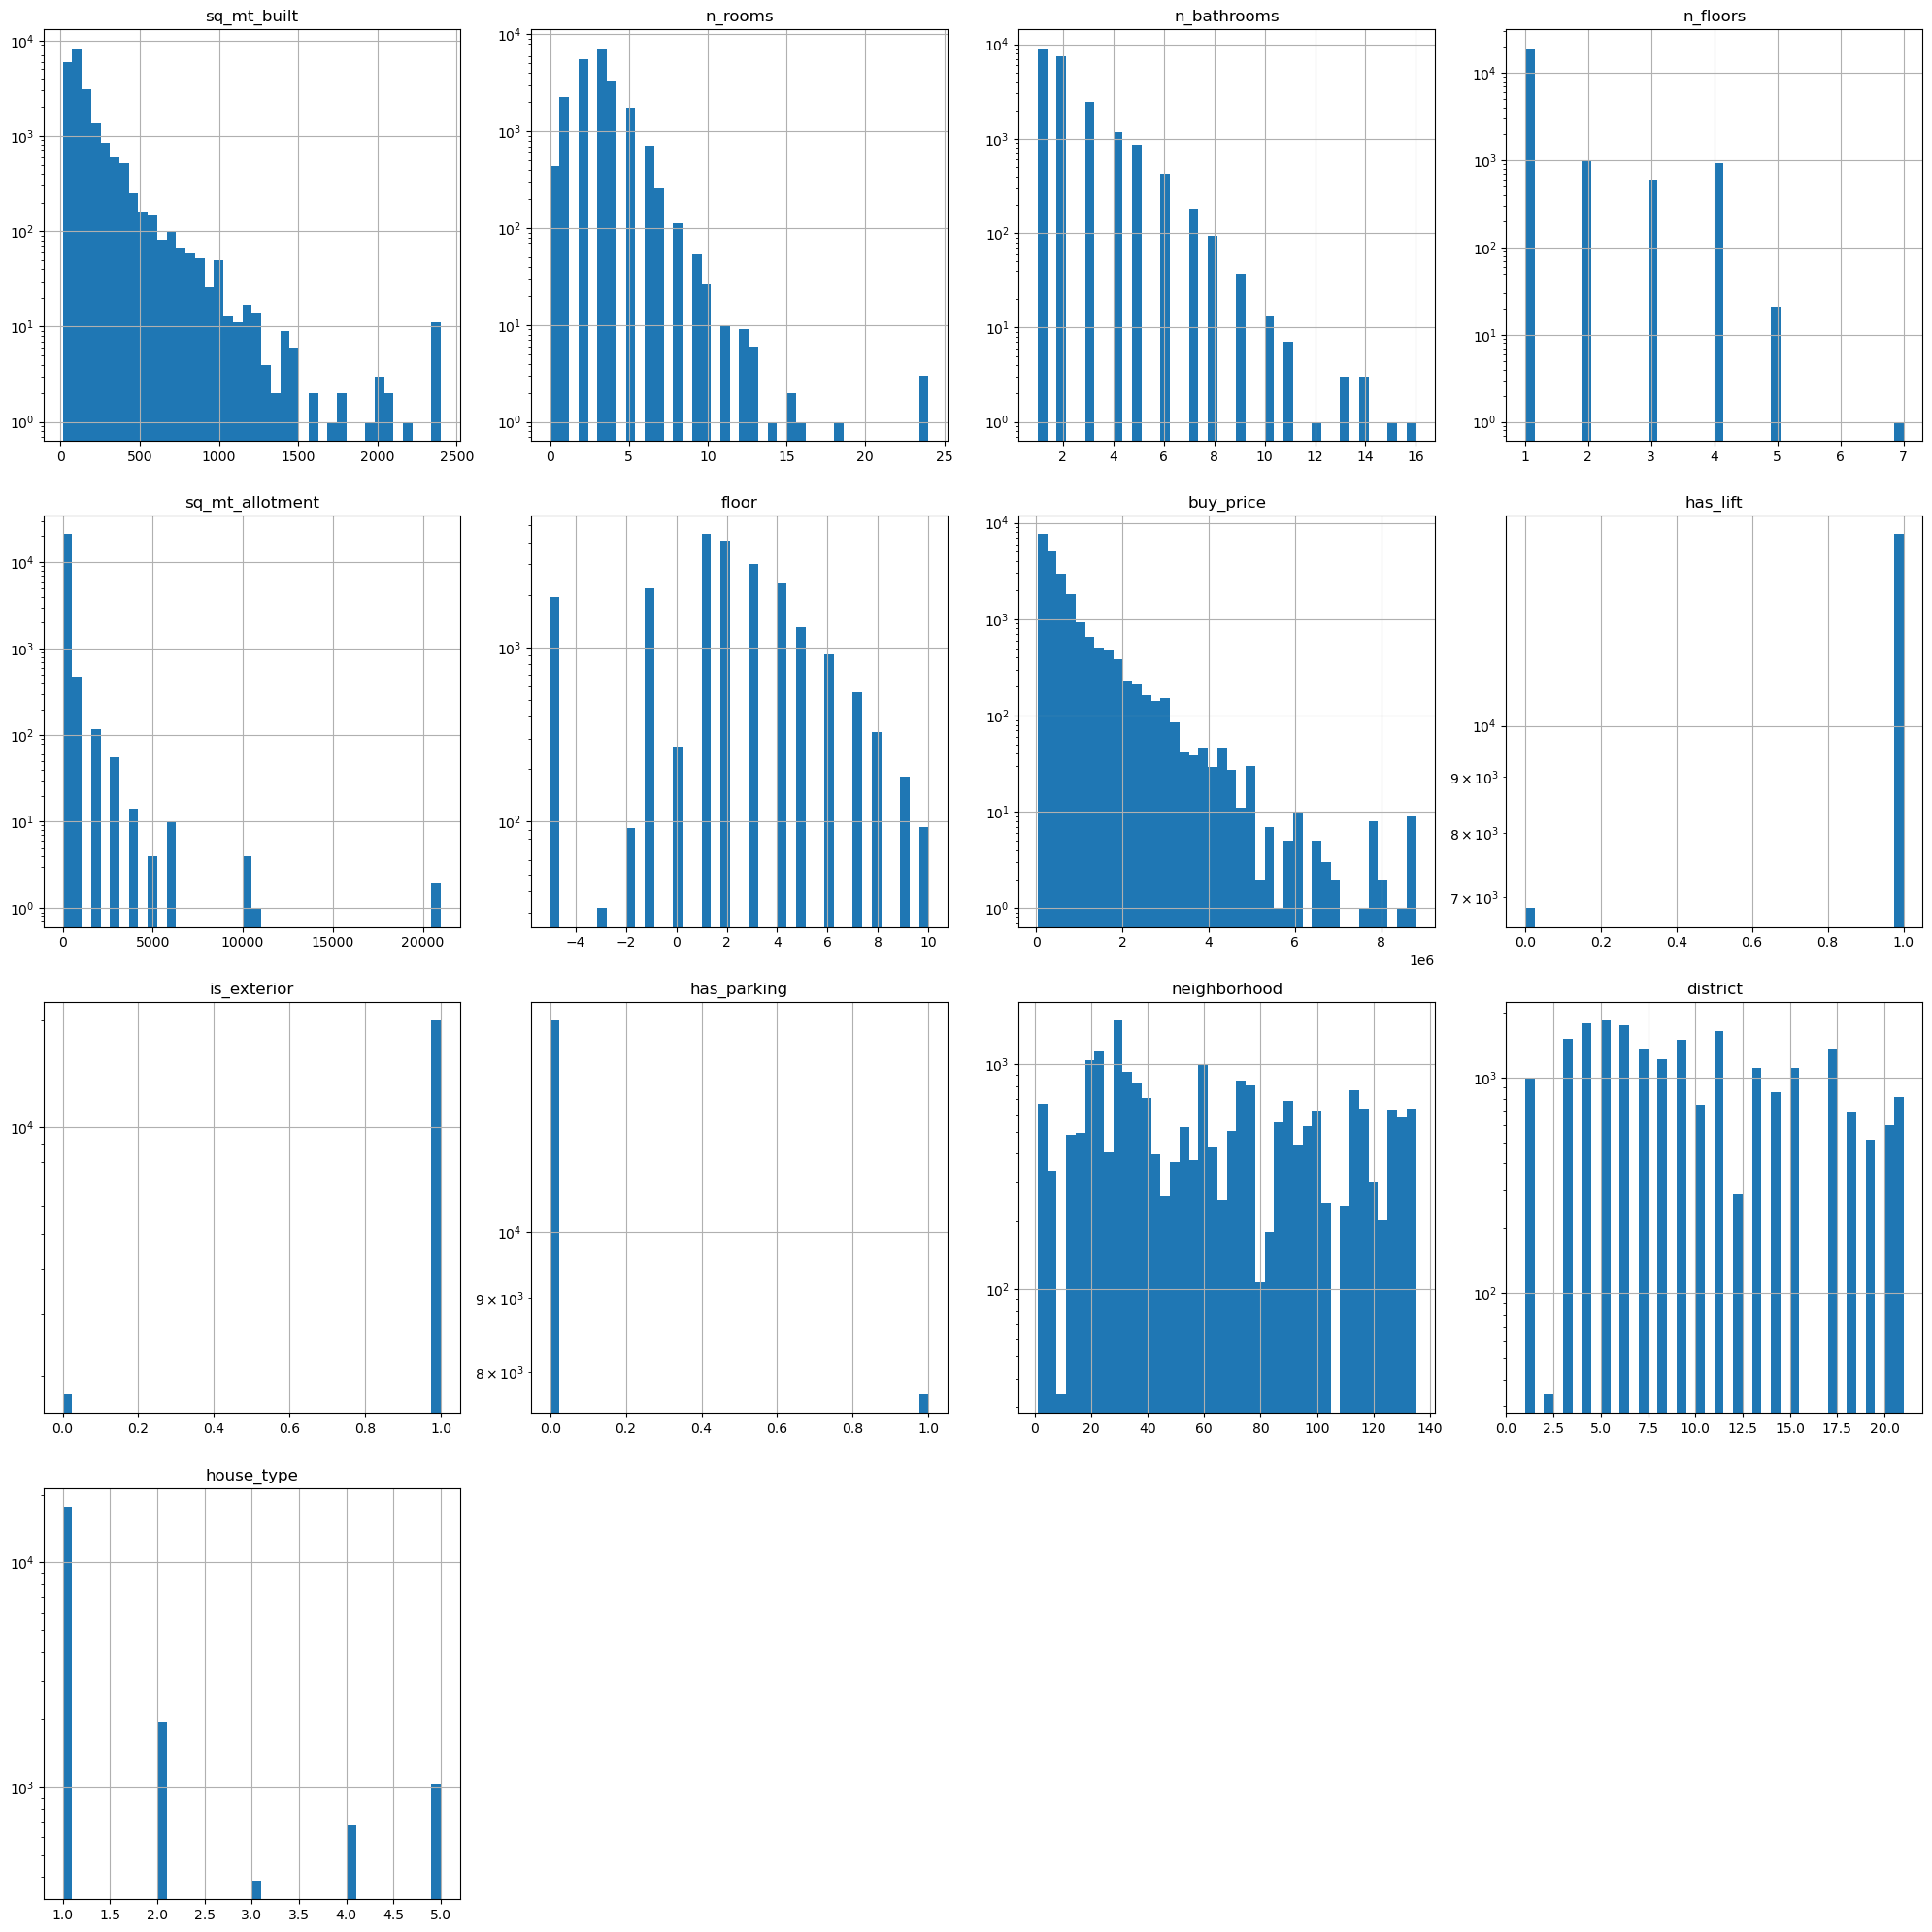

In [47]:
madrid_houses_dataset.hist(bins=40, log=True, figsize=(20, 20))
plt.tight_layout()

Значения аттрибутов цены и размера дома имеют довольно плавное распределение, однако после некоторый величины появляются резкие перепады: после 1000 кв.м для площади дома и 4.000.000 для цены.

## Корреляция аттрибутов

Попробуем проследить зависимость цены, квадратной площади и типа дома.

Заметим, что **больша́я часть данных имеет цену менее 4 млн., а также площадь менее 1000 кв.м**

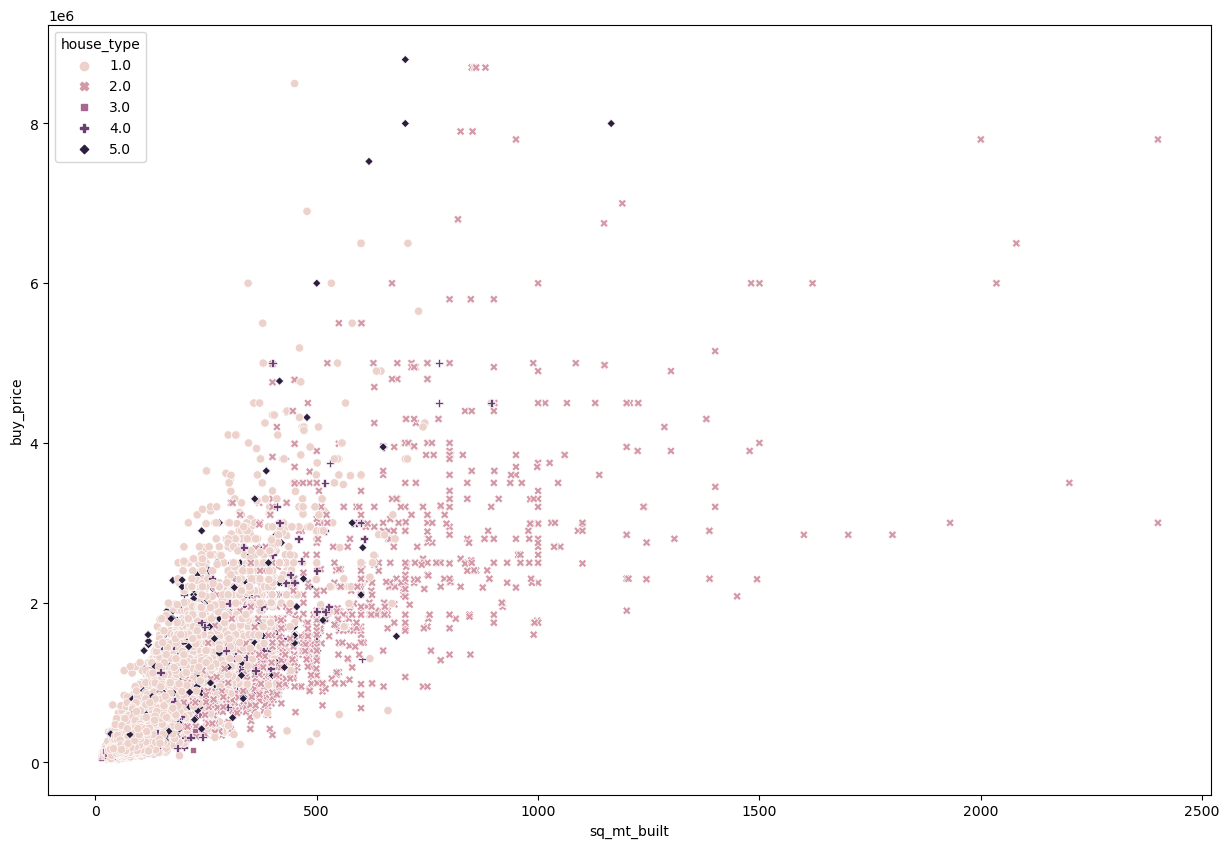

In [48]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='sq_mt_built', y='buy_price', hue='house_type', style='house_type', data=madrid_houses_dataset)
plt.show()

Рассмотрим распределение цен и убедимся в сделанном выводе.

count    2.173800e+04
mean     6.535975e+05
std      7.819757e+05
min      3.600000e+04
25%      1.980000e+05
50%      3.750000e+05
75%      7.627500e+05
max      8.800000e+06
Name: buy_price, dtype: float64


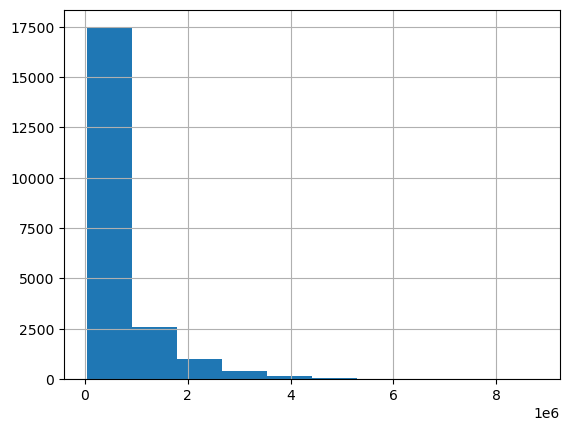

In [49]:
print(madrid_houses_dataset.buy_price.describe())
madrid_houses_dataset.buy_price.hist(bins=10)
plt.show()

Уберем все дома ценой более 4 млн. и более 1000 кв.м. Это небольшая группа, но очень разрозненная. Около 281 домов, 1,3%.

Таким образом уменьшим значения ошибок.

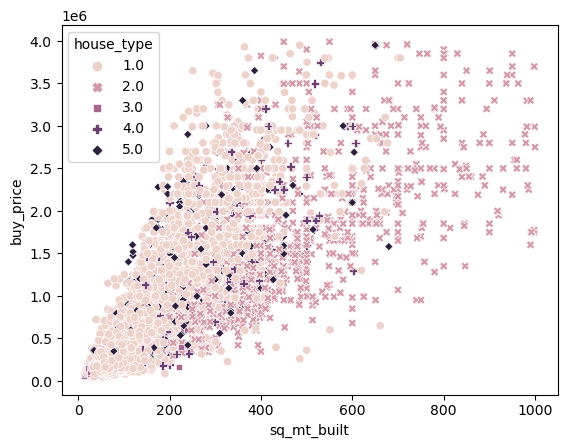

In [50]:
madrid_houses_dataset = madrid_houses_dataset[madrid_houses_dataset.buy_price < 4000000]
madrid_houses_dataset = madrid_houses_dataset[madrid_houses_dataset.sq_mt_built < 1000]
madrid_houses_dataset.describe()

sns.scatterplot(x='sq_mt_built', y='buy_price', hue='house_type', style='house_type', data=madrid_houses_dataset)
plt.show()


Заметим, что средняя цена дома составляет около 600 тыс.

count    2.145700e+04
mean     6.035914e+05
std      6.294284e+05
min      3.600000e+04
25%      1.961600e+05
50%      3.690000e+05
75%      7.450000e+05
max      3.990000e+06
Name: buy_price, dtype: float64


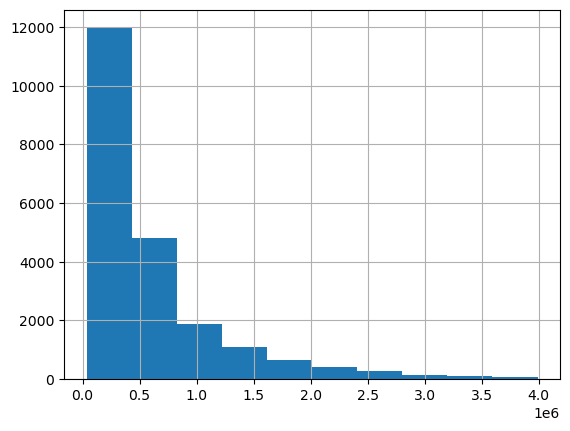

In [51]:
print(madrid_houses_dataset.buy_price.describe())
madrid_houses_dataset.buy_price.hist(bins=10)
plt.show()

Изучим зависимости аттрибутов не касающихся расположения домов.

Как ни странно, **с увеличением площади дома растет и его цена**.

Проследим ожидаемую положительную корреляцию между площадью, числом комнат, числом ванных комнат, количеством этажей, общей площадью дома и ценой.

<AxesSubplot:>

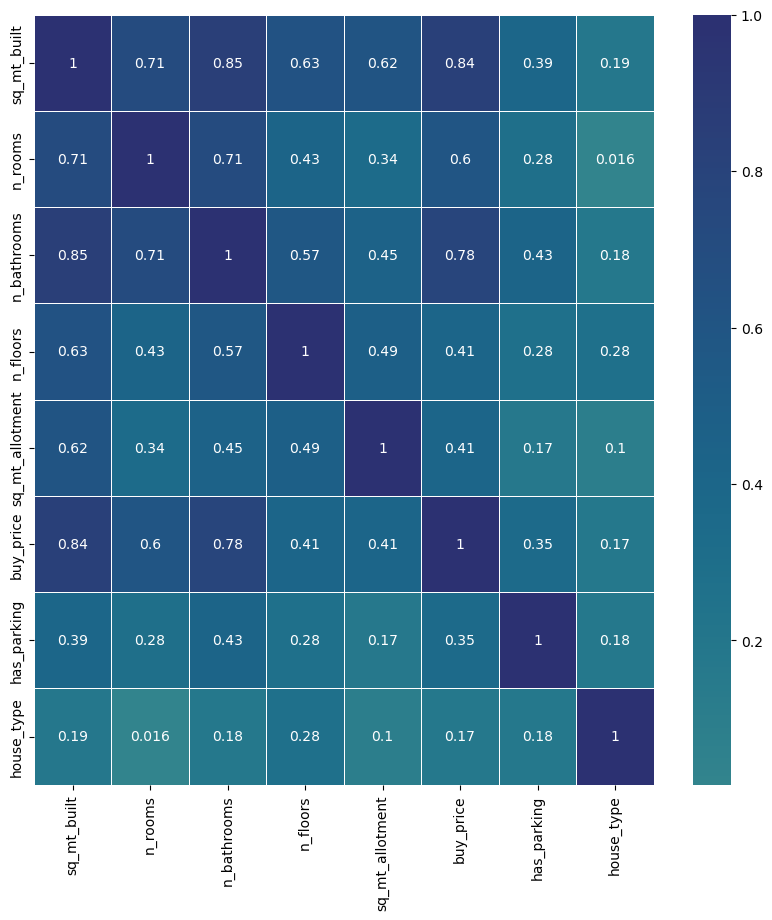

In [59]:
sns.heatmap(madrid_houses_dataset.drop(columns=["floor", "has_lift", "is_exterior", "neighborhood", "district"]).corr(),
            center=0, annot=True, cmap="crest", linewidths=.5, ax=plt.subplots(figsize=(10, 10))[1])

Используя данные о местоположении дома в Мадриде, сделаем выводы о средней стоимости домов в том или ином районе.

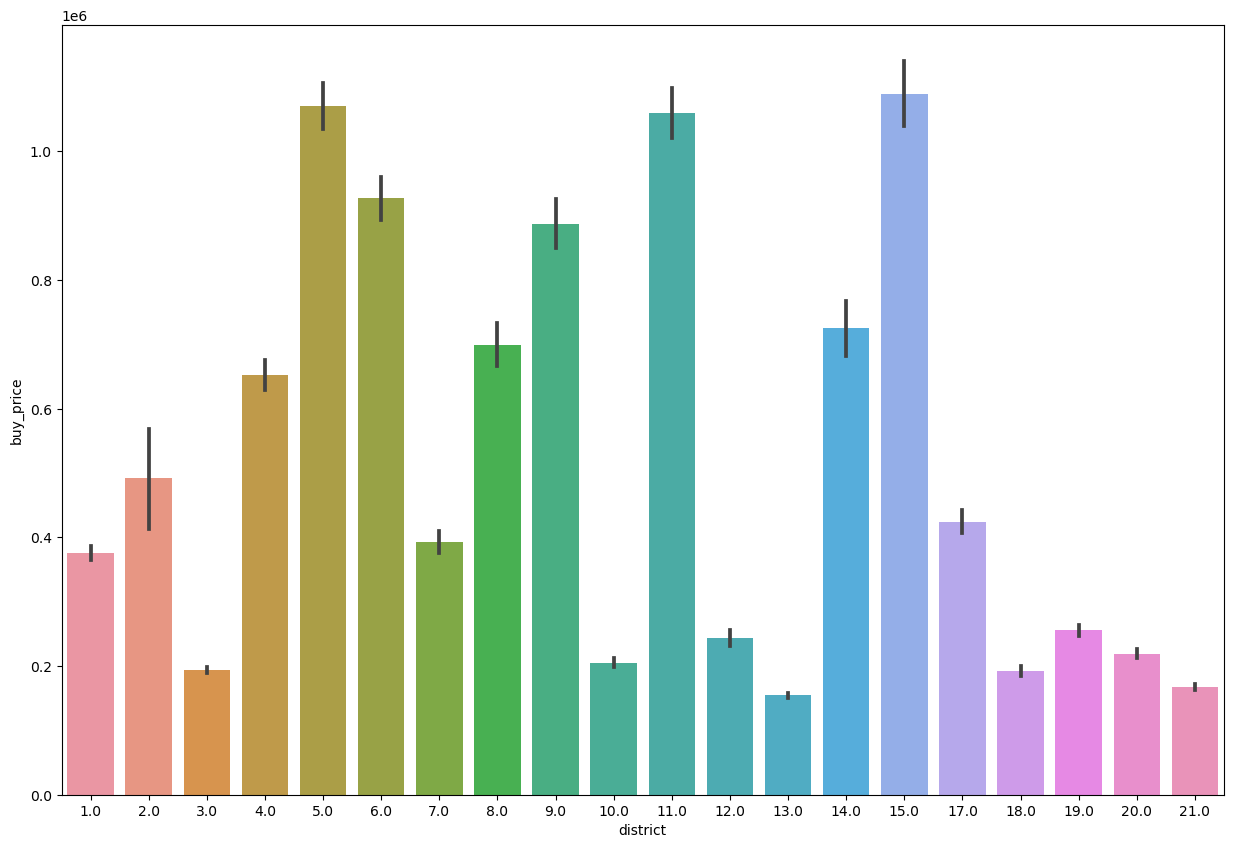

In [60]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='district', y='buy_price', data=madrid_houses_dataset)
plt.show()

Помимо вышесказанного рассмотрим более детальное распределение цен по округу (в данном случае district включает в себя несколько neighborhood). Заметим, **что несмотря на принадлежность домов к одному району, их цена может зависеть от аттрибута neighborhood**.

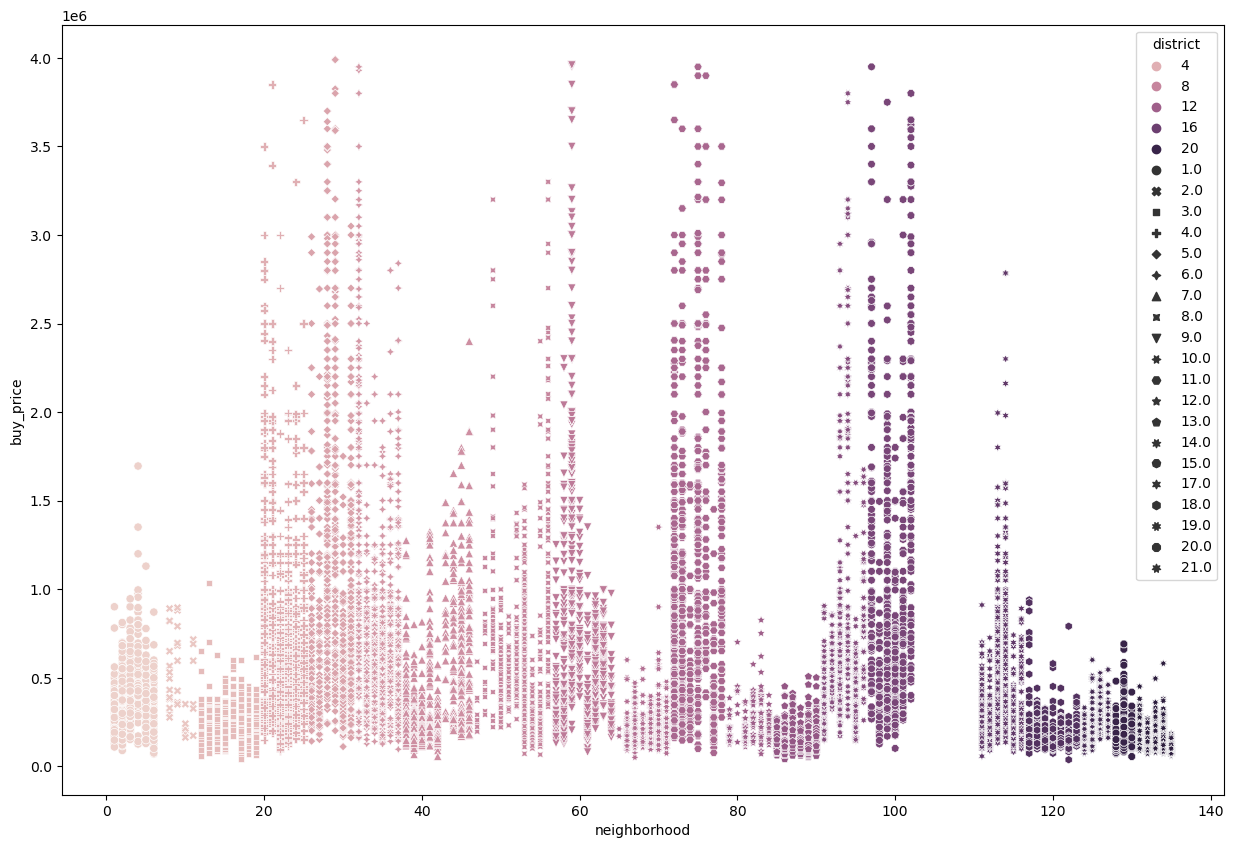

In [81]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(y='buy_price', x='neighborhood', hue="district", style="district", data=madrid_houses_dataset)
plt.show()

Итак, можно ожидать, что размер дома, количество комнат, этажей, а также принадлежность к району и округу, будут ощутимо влиять на целевой аттрибут -- цену дома.